# Using Custom Magic and SVG Table Builder Classes to turn %quickref Magic into a SVG Table.

This notebook uses the SVG table classes here to build SGV tables of the %quickref text.  The github project containing the external files used is [here](https://github.com/damontallen/IPython-quick-ref-sheets).

In [1]:
cd Git_quickref_project/

/home/damon/Documents/CODE/Programing/Python/IPython/Quickref/Git_quickref_project


## Grab the %quickref Text with a New Magic Command

Creating custom(s) command [documentation](http://ipython.org/ipython-doc/dev/interactive/reference.html).

In [2]:
from IPython.core.magic import (magics_class, line_magic)
from IPython.core.magics.basic import BasicMagics #Where _magic_docs is defined, also BasicMagics inherits the Magics already
@magics_class
class MyMagics(BasicMagics):
    @line_magic
    def quickref_text(self, line): 
        """ Return the quickref text to be assigned to a variable """
        from IPython.core.usage import quick_reference
        qr = quick_reference + self._magic_docs(brief=True)
        return qr
            
ip = get_ipython()
ip.register_magics(MyMagics)

quickref_text = %quickref_text

## Convert the %quickref Text to a Dictionary

In [3]:
from Build_dict import build_dict #to build a dictionary out of the %quickref text file

lines = quickref_text.split('\n')
Quick_ref_dic = build_dict(lines) #this parses the text and builds an ordered dict out of it.

#make a list of all the headings
heading =list(Quick_ref_dic.keys())

## Dictionary to SVG Table

In [4]:
def quick_dict_to_SVG(Table_dict, width=500, L_width=200, x_location=0, y_location=0):
    title_color = (173,216,230) #lightblue
    header_color = (213,224,197) #a grey green
    font_family="Arial"
    font_size=12 #font_size=font_size
    header_font_size = 14
    line_width=1 #, line_width=line_width
    #good site for color translations: http://www.yellowpipe.com/yis/tools/hex-to-rgb/color-converter.php
    TL = [x_location, y_location]
    row_horz_shift = 5 #shift the row text over to line up with the header text
    display_text = ''
    for header, values in Table_dict.items():
        entries = list(values.keys())
        #Types = values['_type_'] 
        heading = True #default since most row groups have a heading
        #There are at least one entry unter each header
        for entry, explained in values.items():
            if entry =='_type_': 
                #This entry indicates what type of group of rows this is.
                
                #Select the header color
                if explained == 'Heading':
                    bg = header_color
                elif explained == 'Title':
                    bg = title_color
                else: #for comment or other headerless row groups
                    heading = False #
                    
                if heading:    #Build a header for the table
                    head=Table_Header(text=header, width=width, TL=list(TL), background=bg, font_family=font_family, size=header_font_size, line_width=line_width)
                    bg=header_color
                    display_text += head.get_SVG_header() #add the header
                    TL[1]=head.bottom #Move the top left cordinates
                    spacer = Table_rows(font_size=3, width=width, top_left=list(TL), line_width=line_width)
                    spacer.set_count(1)
                    display_text += spacer.get_SVG_rows() #add a spacer after the header
                    TL[1]=spacer.bottom #Move the top left cordinates
                    
            elif "_Comment_starts_at_" in entry: #This is a block of comments
                
                #make a row with one column and multiple lines of text
                txt = clean_text('\n'.join(explained))
                text_list = [[txt]] #
                rows = Table_rows(top_left=list(TL),width=width,font_family=font_family,font_size=font_size, line_width=line_width)
                rows.set_text_list(text_list)
                rows.x_shift=row_horz_shift
                display_text += rows.get_SVG_rows()
                TL[1]=rows.bottom #Move the top left cordinates
                
            elif "_Multiline_Flag_" in entry: #this is an example that spans multiple lines
                
                #Make a row with two columns and multiple lines of text
                multi_left=[]
                multi_right=[]
                #Multiline row entries are lists of tuple pairs
                for line in explained:
                    left = clean_text(line[0])
                    multi_left.append(left)
                    right = clean_text(line[1])
                    multi_right.append(right)
                multi_left_text = '\n'.join(multi_left)
                multi_right_text = '\n'.join(multi_right)
                text_list = [[multi_left_text,multi_right_text]]
                rows = Table_rows(top_left=list(TL),width=width,font_family=font_family,font_size=font_size, line_width=line_width)
                rows.set_text_list(text_list)
                rows.column_locations=[0,L_width]
                rows.x_shift=row_horz_shift
                display_text += rows.get_SVG_rows()
                TL[1]=rows.bottom      #Move the top left cordinates  
                
            else: #this must be rows of examples and explanation
                rows = Table_rows(top_left=list(TL),width=width,font_family=font_family,font_size=font_size, line_width=line_width)
                text_list = [[clean_text(entry), clean_text(explained)]]
                rows.set_text_list(text_list)
                rows.column_locations=[0,L_width]
                rows.x_shift=row_horz_shift
                display_text += rows.get_SVG_rows()
                TL[1]=rows.bottom #Move the top left cordinates
        
        #Add a spacer at the bottom of the row group
        bot_spacer = Table_rows(font_size=3, width=width, top_left=list(TL), line_width=line_width)
        bot_spacer.set_count(1)
        display_text += bot_spacer.get_SVG_rows()
        TL[1]=bot_spacer.bottom #Move the top left cordinates
        
    return (display_text, width+2*line_width+TL[0], TL[1]+2*line_width)


## Make a table of the Basic commands

In [5]:
from IPython.display import SVG #to display the results
from collections import OrderedDict as Or_dict

In [22]:
#load the SVG Table classes
%run SVG_Table_Classes #used instead of import during editing
#Set the table size
width=502
Left_column_width=170
#Build the SVG text
start_stop = 4 #number of headings to have on the left
Table_dict = Or_dict()
for i in range(0,start_stop): #Grab some headings
    Table_dict[heading[i]]=Quick_ref_dic[heading[i]] 
    
display_text, right, bottom = quick_dict_to_SVG(Table_dict, width=width, L_width=Left_column_width)
running_text = display_text
Bottom = bottom
#print("Right = %d"%right)
Table_dict = Or_dict()
for i in range(start_stop,8): #Grab some headings
    Table_dict[heading[i]]=Quick_ref_dic[heading[i]] 
width=495
Left_column_width=130
display_text, right, bottom = quick_dict_to_SVG(Table_dict, width=width, L_width=Left_column_width, x_location=right+10)
Bottom =max(Bottom , bottom)
running_text += display_text

Text=Set_SVG_view(right, Bottom, running_text)


### Save and display the results...

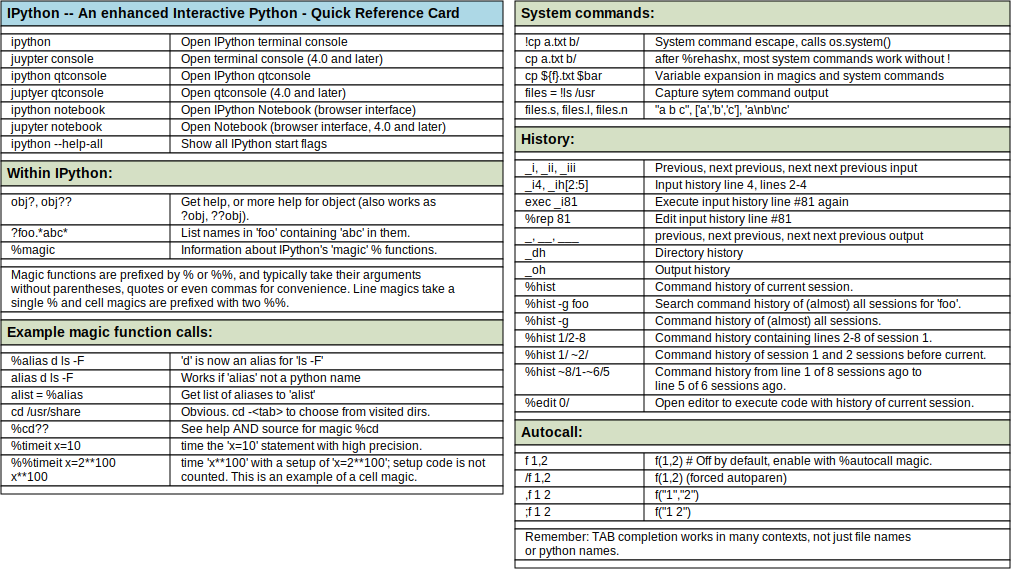

In [23]:
#Save the result

with open("Basic_Help.svg",'w') as f: 
    f.write(Text)

#Display the results
SVG(Text)

## Make a table of the Magic commands

In [30]:
#load the SVG Table classes
%run SVG_Table_Classes #used instead of import during editing (not needed a second time but left in for clarification)
#Set the table lengths
stops = [32+4+5,65+8+10]

#Build the SVG text

#Make a tempory dictionary of the magic heading entries
magic_dict = Or_dict()
magic_dict[heading[-1]]=Quick_ref_dic[heading[-1]] 
entries = list(magic_dict[heading[-1]].keys())

#First table
Table_dict = Or_dict()
magic_dict_list = Or_dict()
for i in range(0,stops[0]): #grab some of the magic entries
    magic_dict_list[entries[i]] = magic_dict[heading[-1]][entries[i]]
#make a table dictionary to display
Table_dict[heading[-1]]=magic_dict_list

width=585
Left_column_width=145
display_text, right, bottom = quick_dict_to_SVG(Table_dict, width=width, L_width=Left_column_width)
Bottom = bottom #keep track of the bottom of the view port
running_text = display_text #start a running total of the display text

#Second table
Table_dict = Or_dict()
magic_dict_list = Or_dict()
for i in range(stops[0],stops[1]): #grab some of the magic entries
    magic_dict_list[entries[i]] = magic_dict[heading[-1]][entries[i]]
#make a table dictionary to display
Table_dict["Continuation"]=magic_dict_list
Table_dict["Continuation"]['_type_']="continuation"
 
width=500
Left_column_width=110#95
display_text, right, bottom = quick_dict_to_SVG(Table_dict, width=width, L_width=Left_column_width, x_location=right+10)
Bottom =max(Bottom , bottom) #keep track of the bottom of the view port
running_text += display_text #Add the diplay text to the running total of text

#Third table
Table_dict = Or_dict()
magic_dict_list = Or_dict()
last = len(entries)
for i in range(stops[1],last): #grab some of the magic entries
    magic_dict_list[entries[i]] = magic_dict[heading[-1]][entries[i]]
#make a table dictionary to display
Table_dict["Continuation"]=magic_dict_list
Table_dict["Continuation"]['_type_']="continuation"

width=525
Left_column_width=90
display_text, right, bottom = quick_dict_to_SVG(Table_dict, width=width, L_width=Left_column_width, x_location=right+10)
Bottom =max(Bottom , bottom) #keep track of the bottom of the view port
running_text += display_text#Add the diplay text to the running total of text

Text=Set_SVG_view(right, Bottom, running_text)

### Save and display the results...

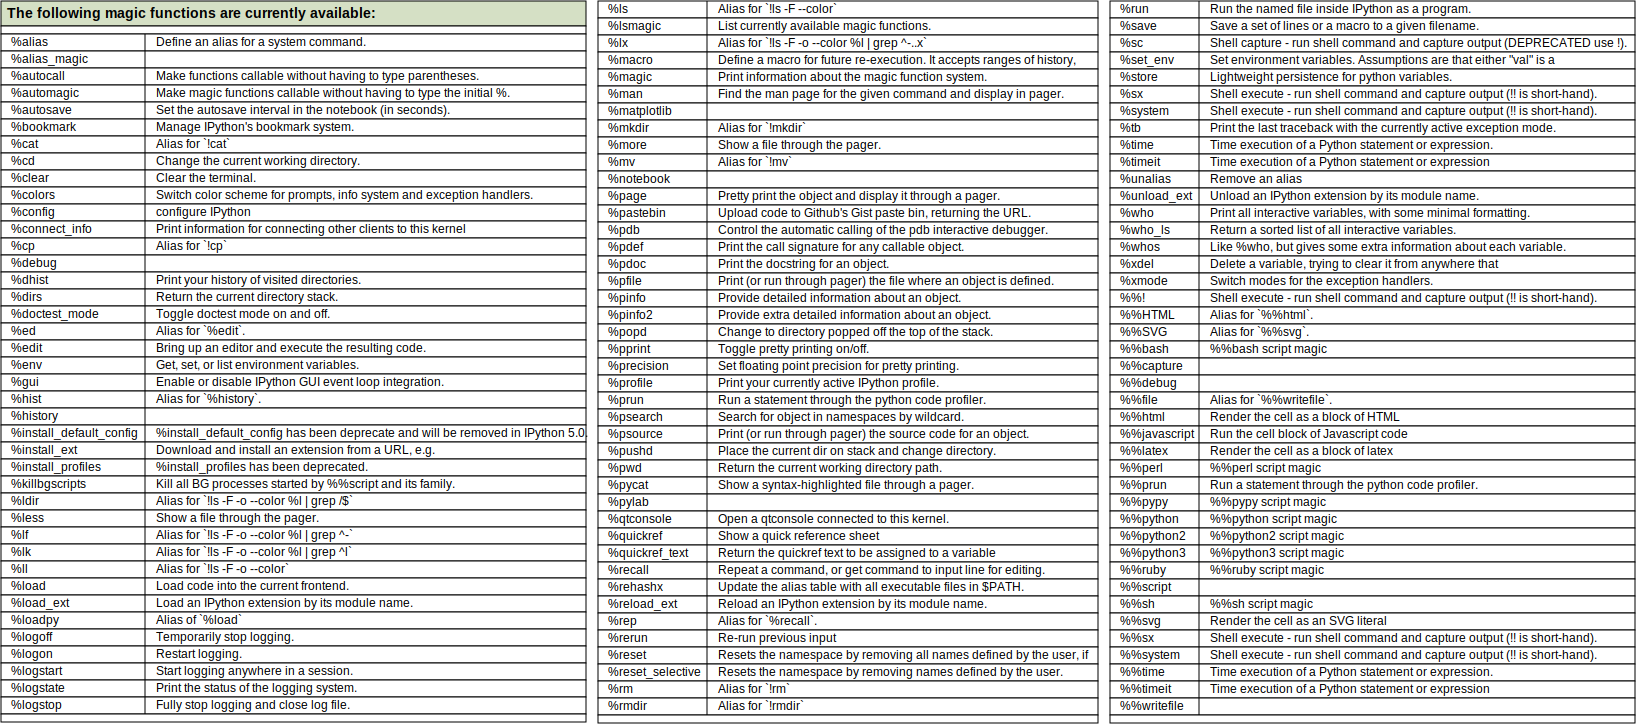

In [31]:
#Save the result

with open("Magic_only.svg",'w') as f:
    f.write(Text)

#Display the results
SVG(Text)

In [32]:
%quickref